<font>
<div dir=ltr align=center>
<img src='https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png' width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Spring 2025<br>
<font color=3C99D size=5>
Practical Assignment 2 - Minimax, MDP and RL <br>
<font color=696880 size=4>
Arman Tahmasebi Zadeh


Welcome! This notebook is all about strategy—or, as some might call it, "policy." Choosing the best action during a game or while solving a real-world problem is one of the most important applications of AI today. In fact, it could even be considered a core definition of intelligence. Here, you’ll explore several approaches to tackling this challenge, each with its own strengths and weaknesses.

For now, let’s start by importing the necessary tools. Feel free to add additional imports if you like, though it's unlikely you'll need more than what's provided.

In [1]:
import numpy as np
from gymnasium import Env, spaces
import matplotlib.pyplot as plt
from collections import defaultdict
import imageio
from IPython.display import HTML
from base64 import b64encode
import gymnasium as gym
import random
import os
from PIL import Image, ImageDraw
import math
import matplotlib.animation as animation
import networkx as nx
from numpy.linalg import norm
import copy
from functools import partial

Now, to the main part...

# Minimax
One classic method we'll encounter is the minimax algorithm, a foundational strategy used primarily in two-player games. Minimax assumes both players act optimally and tries to minimize the possible loss for a worst-case scenario—essentially planning ahead by considering the best moves for yourself and the best counter-moves for your opponent.

## Onitama

In this section, a simpler version of the board game **Onitama** is implemented. This game has mechanics similar to chess, but with a unique twist: the available moves for each player's pieces change at the end of each round.

Onitama is played on a 5x5 board. Each player controls five pieces—one Master and four Students. The objective is to either capture the opponent's Master or move your own Master onto the opponent's temple arch space.

At any given time, each player has two movement cards that dictate how their pieces can move. A fifth card sits aside and rotates into play: when a player uses a move from one of their two cards, that card is then swapped with the spare card. This continuous rotation of moves adds a strategic layer, forcing players to think not just about their own plans, but also about what moves they are giving to their opponent.

In the simplified version implemented here, we focus on the core movement and card-swapping mechanics, while leaving out some of the more subtle complexities of the full game.



![Onitama Board Game](Onitama.png)


### Simplifications
In the implemented version, some rules are different from the main game:
- The only way to win is to capture all of your opponent's pieces.
- Each player has only one move card.
- The size of the board can vary. The number of pieces on each side is board size - 2.
- There is no Master piece, all of the pieces are Students.

---

### Game Rules
Each card in the game represents a set of moves, implemented as an array of tuples. In the card visualization, the center shows your piece's position, and all of the other colored squares show all of the possible moves that can be done using that card. For instance, using COBRA, you can either move one of your pieces left, top-right or bottom-right for one square.

At the start of each round:
- The current player selects one of the moves on the card.
- He then selects one of his remaining pieces.
- The move is applied to the piece, if it is valid, meaning that it does not land on another one of your own pieces or it goes out of border.
- If a piece lands on an enemy piece, the enemy piece is destroyed and removed from the board.
- If there is a possible move, it must be taken.
- If there are no possible moves, the player does nothing and passes his turn.
- After the move is done, his card is swapped with the center card.
- Current player's turn is over

Pay attention to the fact that the cards rotate when swapped, meaning that if I can go two squares forward with TIGER, my opponent can go two squares forward with it as well, with respect to his point of view, which happens to be two squares backward for me.

---

A sample run of the game is implemented below. You can also go and watch a short video on how to play Onitama to understand better. 

You don't need to change any parts of the following two cells, although you can add some custom cards to `ALL_CARDS` and play with them instead of the default ones

In [2]:
ALL_CARDS = {
    "Tiger": [(0, 2), (0, -1)],
    "Dragon": [(-2, 1), (2, 1), (-1, -1), (1, -1)],
    "Frog": [(-2, 0), (-1, 1), (1, -1)],
    "Rabbit": [(1, 1), (-1, -1), (2, 0)],
    "Crab": [(-2, 0), (0, 1), (2, 0)],
    "Elephant": [(-1, 1), (1, 1), (-1, 0), (1, 0)],
    "Goose": [(-1, 1), (0, 1), (0, -1), (1, -1)],
    "Rooster": [(1, 1), (0, 1), (0, -1), (-1, -1)],
    "Monkey": [(-1, 1), (1, 1), (-1, -1), (1, -1)],
    "Mantis": [(-1, 1), (1, 1), (0, -1)],
    "Horse": [(0, 1), (-1, 0), (0, -1)],
    "Ox": [(0, 1), (1, 0), (0, -1)],
    "Crane": [(0, 1), (-1, -1), (1, -1)],
    "Boar": [(-1, 0), (0, 1), (1, 0)],
    "Eel": [(-1, 1), (1, 0), (-1, -1)],
    "Cobra": [(1, 1), (-1, 0), (1, -1)],
    
    "Your Custom Card": [(10, 10)],
}

![Onitama Cards](OnitamaCards.jpg)

In [3]:
class Onitama:
    def __init__(
            self, 
            board_size=5, 
            my_symbol='o', 
            opponent_symbol='x', 
            card1="Tiger", 
            card2="Crab", 
            card3="Elephant", 
            figsize=(9, 6), # Changes the animation size
            render_interval=800 # Changes the time between frames
            ):
        self.board_size = board_size
        self.my_symbol = my_symbol
        self.opponent_symbol = opponent_symbol
        self.card1 = card1
        self.card2 = card2
        self.card3 = card3
        self.figsize = figsize
        self.interval = render_interval
        
        m = 0
        for c in [ALL_CARDS.get(card1), ALL_CARDS.get(card2), ALL_CARDS.get(card3)]:
            for a, b in c:
                if abs(a) > m:
                    m = abs(a)
                if abs(b) > m:
                    m = abs(b)
        self.max_move = m

    def _init_board(self):
        board = [['.' for _ in range(self.board_size)] for _ in range(self.board_size)]
        for i in range(1, self.board_size - 1):
            board[0][i] = self.opponent_symbol
            board[-1][i] = self.my_symbol
        return board

    def init_game(self):
        return {
            "board": self._init_board(),
            "turn": 1,  # 1 = You, -1 = Opponent
            "my_card": self.card1,
            "opponent_card": self.card2,
            "center": self.card3,
        }

    def get_pieces(self, board, player):
        symbol = self.my_symbol if player == 1 else self.opponent_symbol
        return [(r, c) for r in range(self.board_size) for c in range(self.board_size) if board[r][c] == symbol]

    def apply_move(self, state, from_pos, to_pos):
        next_state = copy.deepcopy(state)
        r1, c1 = from_pos
        r2, c2 = to_pos
        piece = next_state["board"][r1][c1]
        next_state["board"][r1][c1] = '.'
        next_state["board"][r2][c2] = piece

        if next_state["turn"] == 1:
            next_state["my_card"], next_state["center"] = next_state["center"], next_state["my_card"]
        else:
            next_state["opponent_card"], next_state["center"] = next_state["center"], next_state["opponent_card"]

        next_state["turn"] *= -1
        return next_state

    def in_bounds(self, r, c):
        return 0 <= r < self.board_size and 0 <= c < self.board_size

    def generate_moves(self, state):
        moves = []
        board = state["board"]
        player = state["turn"]
        card = state["my_card"] if player == 1 else state["opponent_card"]
        pieces = self.get_pieces(board, player)

        for (r, c) in pieces:
            for (dx, dy) in ALL_CARDS[card]:
                dc, dr = (-dx, -dy) if player == 1 else (dx, dy)
                nr, nc = r + dr, c + dc
                if self.in_bounds(nr, nc):
                    target = board[nr][nc]
                    if player == 1 and target != self.my_symbol:
                        moves.append((r, c, nr, nc))
                    elif player == -1 and target != self.opponent_symbol:
                        moves.append((r, c, nr, nc))
        return moves

    def evaluate(self, state):
        flat = [cell for row in state["board"] for cell in row]
        return flat.count(self.my_symbol) - flat.count(self.opponent_symbol)

    def terminal(self, state):
        if all(cell != self.opponent_symbol for row in state["board"] for cell in row):
            return True, 1
        if all(cell != self.my_symbol for row in state["board"] for cell in row):
            return True, -1
        return False, 0

    def _render(self, states):
        fig, axs = plt.subplots(2, 3, figsize=self.figsize, height_ratios=[1, 4], width_ratios=[1, 4, 1])

        ax_opp, ax_center, ax_player = axs[0]
        ax_board = axs[1][1]

        axs[1][0].axis('off')
        axs[1][2].axis('off')

        def render_card_moves(ax, card_name, is_opponent, max_move):
            s = 2 * max_move + 1
            ax.clear()
            ax.set_xticks(np.arange(s))
            ax.set_yticks(np.arange(s))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xlim(-0.5, s - 0.5)
            ax.set_ylim(-0.5, s - 0.5)
            ax.grid(True)
            ax.set_aspect('equal')
            ax.set_title(card_name, fontsize=10)

            origin = (max_move, max_move)
            ax.add_patch(plt.Circle(origin, 0.2, color='black'))

            for dx, dy in ALL_CARDS.get(card_name, []):
                if is_opponent:
                    dx, dy = -dx, -dy
                x = origin[0] + dx
                y = origin[1] + dy
                if 0 <= x < s and 0 <= y < s:
                    ax.add_patch(plt.Circle((x, y), 0.2, color='blue'))

        def set_card_text(ax, card_name, label, color, max_move):
            render_card_moves(ax, card_name, label == "Opponent", max_move)
            ax.set_title(f"{label}: {card_name}", fontsize=10, color=color)

        def draw_board(state, my_symbol, opponent_symbol, board_size):
            ax_board.clear()
            ax_board.set_xticks(np.arange(board_size))
            ax_board.set_yticks(np.arange(board_size))
            ax_board.set_xticklabels([])
            ax_board.set_yticklabels([])
            ax_board.set_xlim(-0.5, board_size - 0.5)
            ax_board.set_ylim(-0.5, board_size - 0.5)
            ax_board.grid(True)
            ax_board.set_title("Onitama", fontsize=14)

            board = state["board"]
            for r in range(board_size):
                for c in range(board_size):
                    piece = board[r][c]
                    if piece == my_symbol:
                        ax_board.text(c, board_size - 1 - r, my_symbol, ha='center', va='center', fontsize=18, color='blue', weight='bold')
                    elif piece == opponent_symbol:
                        ax_board.text(c, board_size - 1 - r, opponent_symbol, ha='center', va='center', fontsize=18, color='red', weight='bold')

        def update(frame_idx, my_symbol, opponent_symbol, board_size, max_move):
            state = states[frame_idx]
            draw_board(state, my_symbol, opponent_symbol, board_size)

            set_card_text(ax_opp, state.get("opponent_card", ""), "Opponent", "red", max_move)
            set_card_text(ax_center, state.get("center", ""), "Center", "black", max_move)
            set_card_text(ax_player, state.get("my_card", ""), "You", "blue", max_move)

            if "winner" in state:
                winner = state["winner"]
                if winner == 1:
                    ax_board.set_title("Game Over: Player Wins", fontsize=14)
                elif winner == -1:
                    ax_board.set_title("Game Over: Opponent Wins", fontsize=14)
                else:
                    ax_board.set_title("Game Over: Draw", fontsize=14)

        ani = animation.FuncAnimation(fig, partial(update, my_symbol=self.my_symbol, opponent_symbol=self.opponent_symbol, board_size=self.board_size, max_move=self.max_move), frames=len(states), interval=self.interval, repeat=False)
        plt.close(fig)
        return HTML(ani.to_jshtml())


    def run(self, agent1, agent2, render=True):
        state = self.init_game()
        states = [copy.deepcopy(state)]

        while True:
            terminal, winner = self.terminal(state)
            if terminal:
                state["winner"] = winner
                states.append(copy.deepcopy(state))
                break
            
            turn = state["turn"] == 1

            if turn:
                move = agent1.make_move(state)
            else:
                move = agent2.make_move(state)

            if move is None:
                state["winner"] = 0
                states.append(copy.deepcopy(state))
                break

            r1, c1, r2, c2 = move
            state = self.apply_move(state, (r1, c1), (r2, c2))
            states.append(copy.deepcopy(state))

        if render:
            return self._render(states)
        elif "winner" in states[-1]:
                winner = states[-1]["winner"]
                if winner == 1:
                    print("Game Over: Player Wins")
                elif winner == -1:
                    print("Game Over: Opponent Wins")
                else:
                    print("Game Over: Draw")

## Agents
Different algorithms that interact with the environment are called agents. They all inherit from an `Agent` class, and must have a `make_move` function. We will implement a random moving agent as an example.

In [4]:
class Agent:
    def make_move(self, state):
        pass

class RandomAgent(Agent):
    def __init__(self, game: Onitama):
        self.game = game
    
    def make_move(self, state):
        moves = self.game.generate_moves(state)
        if len(moves) > 0:
            return random.choice(moves)
        else:
            return (0, 0, 0, 0)

### Minimax Agent
Now your task is to implement minimax agents, once as a simple minimax algorithm and the second time with alpha-beta pruning. These functions from the game might prove useful to your implementation:
- `generate_moves(state)`: Takes a state and returns a list of all possible moves.
- `terminal(state)`: Returns `terminal, winner`, a boolean showing if the state is a terminal state, and if it is who is the winner (-1=opponent, 1=us, 0=draw)
- `apply_move(state, from, to)`: Takes a move by its start and end, then implements it on the state. You can use it anytime as it effects the state not the game itself.
- `run(agent1, agent2)`: Takes two agents and simulates a game between them, with the option to render the result as an animation.
- `evaluate(state)`: Returns an integer to evaluate how good or bad the state is. You can use it to do a shallow minimax search and terminate when reaching a certain depth.
- `get_pieces(board, player)`: Returns a list of all your pieces' information.

In [5]:
class Minimax(Agent):
    def __init__(self, game: Onitama, maximizing, depth):
        self.game = game
        self.maximizing = maximizing
        self.depth = depth

    def make_move(self, state):
        _, move = self.minimax_search(state, self.depth, self.maximizing)
        return move

    def minimax_search(self, state, depth, is_max_turn):
        terminal, winner = self.game.terminal(state)
        if terminal or depth == 0:
            return self.game.evaluate(state), None

        best_value = float('-inf') if is_max_turn else float('inf')
        best_action = None
        
        for move in self.game.generate_moves(state):
            next_state = self.game.apply_move(
                state, 
                (move[0], move[1]),  
                (move[2], move[3])  
            )
            
            current_val, _ = self.minimax_search(
                next_state, 
                depth-1, 
                not is_max_turn
            )
            
            if is_max_turn:
                if current_val > best_value:
                    best_value = current_val
                    best_action = move
            else:
                if current_val < best_value:
                    best_value = current_val
                    best_action = move
        
        return best_value, best_action

In [6]:
class AlphaBeta(Agent):
    def __init__(self, game: Onitama, maximizing, depth):
        self.game = game
        self.maximizing = maximizing
        self.depth = depth

    def make_move(self, state):
        alpha = -math.inf
        beta = math.inf
        _, move = self.ab_search(state, self.depth, alpha, beta, self.maximizing)
        return move

    def ab_search(self, state, depth, alpha, beta, is_maximizing):
        terminal, winner = self.game.terminal(state)
        if terminal or depth == 0:
            return self.game.evaluate(state), None

        best_value = -math.inf if is_maximizing else math.inf
        best_move = None
        
        for move in self.game.generate_moves(state):
            next_state = self.game.apply_move(
                state,
                (move[0], move[1]),
                (move[2], move[3])
            )
            
            current_val, _ = self.ab_search(
                next_state,
                depth-1,
                alpha,
                beta,
                not is_maximizing
            )
            
            if is_maximizing:
                if current_val > best_value:
                    best_value = current_val
                    best_move = move
                alpha = max(alpha, best_value)
            else:
                if current_val < best_value:
                    best_value = current_val
                    best_move = move
                beta = min(beta, best_value)
            
            if alpha >= beta:
                break
        
        return best_value, best_move

## Playground
In this part you can make different agents with different settings, and simulate the result of their battle. You can also specify the game's settings as you desire!

In [7]:
onitama_settings = {
    "board_size": 5, 
    "my_symbol": 'o', 
    "opponent_symbol": 'x', 
    "card1": "Tiger", # Your starting card
    "card2": "Crab", # Opponent starting card
    "card3": "Elephant", # Center card
    "figsize": (9, 6), # Changes the animation size
    "render_interval": 800 # Changes the time between frames           
}

game = Onitama(**onitama_settings)

# agent1 = RandomAgent(game)
# agent2 = RandomAgent(game)

# Other options
agent1 = Minimax(game, True, 5)
agent2 = AlphaBeta(game, True, 3)

game.run(agent1, agent2, render=True)

# MDP

Markov Decision Processes (MDPs) provide a powerful framework for modeling and analyzing real-world problems. An MDP is defined by a set of states, a set of actions, a transition function `T(s, a, s')` that gives the probability of transitioning from state s to state s' when taking action a, and a reward function `R(s, a, s')` that specifies the reward received for making that transition.


## Scotland Yard

**Scotland Yard** is a classic board game of cat and mouse. Several police officers work together to try to capture a thief known as **Mr. X**. 

At each turn, both the police officers and Mr. X move to different parts of London, choosing from three possible modes of transportation: `Taxi`, `Bus`, or a `Tunnel`. 

Mr. X loses if he is caught by one of the officers, but wins if he manages to evade capture and escape for long enough without being found.


### Simplifications

In the implemented version, several simplifications are applied:
- There is only one police officer, which you control.
- Mr. X moves randomly and cannot escape the city.
- In every city (node), all three transportation options—Taxi, Bus, and Tunnel—are always available.
- The current position of Mr. X is known at all times.

---

### Game Rules

The police officer and Mr. X move along the nodes of a graph. At each turn, the officer can choose one of three actions: `Taxi`, `Bus`, or `Tunnel`. Each node has exactly one neighboring node associated with each action.

When the officer attempts a move:
- With some probability, the intended move is successful, and the officer follows the corresponding path.
- If the move fails, the officer randomly takes one of the two alternative paths, each with equal probability.

After the officer moves, Mr. X may make a move with some probability. If Mr. X decides to move, he randomly selects one of the three available paths from his current location. Otherwise, he remains in place.

If **after both actions** the officer and Mr. X are at the same node, the officer wins and receives the `winning reward`. Otherwise, a `living reward` is applied, and the game continues.

The move success probabilities for each action, along with the movement costs and Mr. X's behavior probabilities, can be customized to different values.

---

Most of the environment has been implemented below—except for the transition matrix `T` and the reward matrix `R`.  
Your task is to complete the final function of the environment class, calculating `T` and `R` based purely on the environment's definition, **without taking samples from the environment**.

You can run the cell after this for a visualization of the game. You can also use `self.state_index`, `self.index_state` and `self.action_index` to convert each actions and states to integers representing them in the environment.


![Scotland Yard](ScotlandYard.jpg)

In [8]:
class ScotlandYard:
    def __init__(
            self,
            police_start="A",
            x_start="J",
            move_probs=[0.9, 0.9, 0.9],
            x_stay_prob=0.1,
            win_reward=5,
            living_reward=-1,
            moving_rewards=[0, 0, 0],
            render_interval=1000,
            figsize=(6, 6),
            color_map={"taxi": "gold", "bus": "blue", "tunnel": "black"},
            ):

        self.police_start = police_start
        self.x_start = x_start
        self.move_probs = move_probs
        self.x_stay_prob = x_stay_prob
        self.win_reward = win_reward
        self.living_reward = living_reward
        self.moving_rewards = moving_rewards
        self.interval = render_interval
        self.figsize = figsize
        self.color_map = color_map

        self.actions = ["bus", "taxi" , "tunnel"]
        self.city_graph = {
            "A": {"taxi": "B", "bus": "C", "tunnel": "D"},
            "B": {"taxi": "A", "bus": "F", "tunnel": "C"},
            "C": {"taxi": "D", "bus": "A", "tunnel": "B"},
            "D": {"taxi": "C", "bus": "E", "tunnel": "A"},
            "E": {"taxi": "H", "bus": "D", "tunnel": "I"},
            "F": {"taxi": "G", "bus": "B", "tunnel": "J"},
            "G": {"taxi": "F", "bus": "I", "tunnel": "H"},
            "H": {"taxi": "E", "bus": "J", "tunnel": "G"},
            "I": {"taxi": "J", "bus": "G", "tunnel": "E"},
            "J": {"taxi": "I", "bus": "H", "tunnel": "F"},
        }
        self.cities = list(self.city_graph.keys())
        self.history = []
        self.states = [(p, x) for p in self.cities for x in self.cities]
        self.state_index = {s: i for i, s in enumerate(self.states)}
        self.index_state = {i: s for i, s in enumerate(self.states)}
        self.action_index = {a: i for i, a in enumerate(self.actions)}
        self._init_T_and_R()
        self.reset()

    def reset(self, random_start=True):
        if random_start:
            self.police_pos, self.x_pos = random.sample(self.cities, 2)
        else:
            self.police_pos = self.police_start
            self.x_pos = self.x_start
        self.done = False
        self.history = [(self.police_pos, self.x_pos)]
        return (self.police_pos, self.x_pos)

    def get_neighbors(self, pos):
        return list(set(self.city_graph[pos].values()))

    def move_mr_x(self):
        if random.random() < self.x_stay_prob:
            return self.x_pos
        neighbors = self.get_neighbors(self.x_pos)
        return random.choice(neighbors)

    def step(self, action):
        if self.done:
            raise ValueError("Game has ended. Call reset() to restart.")

        success = random.random() < self.move_probs[self.actions.index(action)]
        if success:
            new_police_pos = self.city_graph[self.police_pos][action]
        else:
            fallback_options = [a for a in self.actions if a != action and a in self.city_graph[self.police_pos]]
            if fallback_options:
                new_action = random.choice(fallback_options)
                new_police_pos = self.city_graph[self.police_pos][new_action]
            else:
                new_police_pos = self.police_pos

        new_x_pos = self.move_mr_x()

        self.police_pos = new_police_pos
        self.x_pos = new_x_pos
        self.history.append((self.police_pos, self.x_pos))

        if self.police_pos == self.x_pos:
            self.done = True
            reward = self.win_reward
        else:
            reward = self.living_reward

        reward += self.moving_rewards[self.actions.index(action)]

        return (self.police_pos, self.x_pos), reward, self.done

    def render(self):
        G = nx.Graph()
        edge_colors = []

        for node, transports in self.city_graph.items():
            for mode, neighbor in transports.items():
                if G.has_edge(node, neighbor):
                    continue
                G.add_edge(node, neighbor, transport=mode)
                edge_colors.append(self.color_map[mode])

        pos = nx.spring_layout(G, seed=23)
        fig, ax = plt.subplots(figsize=self.figsize)

        def update(frame):
            ax.clear()

            transport_labels = nx.get_edge_attributes(G, "transport")
            edge_colors_frame = [self.color_map[transport_labels[e]] for e in G.edges()]
            nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue',
                    edge_color=edge_colors_frame, node_size=500, font_size=10, width=2)

            police, x = self.history[frame]

            nx.draw_networkx_nodes(G, pos, nodelist=[police], node_color='green', node_size=600, ax=ax)
            nx.draw_networkx_nodes(G, pos, nodelist=[x], node_color='red', node_size=600, ax=ax)

            ax.set_title(f"Step {frame+1}: Police at {police}, Mr. X at {x}")

        ani = animation.FuncAnimation(fig, update, frames=len(self.history), interval=self.interval, repeat=False)
        plt.close(fig)
        return HTML(ani.to_jshtml())

    def _init_T_and_R(self):
        S = len(self.states)
        A = len(self.actions)
        self.T = np.zeros((S, A, S))
        self.R = np.zeros((S, A, S))

        for current_state in self.states:
            police_pos, mr_x_pos = current_state
            if police_pos == mr_x_pos:
                continue 

            current_state_idx = self.state_index[current_state]

            
            mr_x_moves = [
                mr_x_pos,
                self.city_graph[mr_x_pos]["taxi"],
                self.city_graph[mr_x_pos]["bus"],
                self.city_graph[mr_x_pos]["tunnel"]
            ]

            for action in self.actions:
                action_idx = self.action_index[action]

                intended_move = self.city_graph[police_pos][action]
                alt1_move = self.city_graph[police_pos][self.actions[(action_idx + 1) % 3]]
                alt2_move = self.city_graph[police_pos][self.actions[(action_idx + 2) % 3]]
                police_moves = [intended_move, alt1_move, alt2_move]
                move_probs = [
                    self.move_probs[action_idx],
                    (1 - self.move_probs[action_idx]) / 2,
                    (1 - self.move_probs[action_idx]) / 2
                ]

                for p_move, p_prob in zip(police_moves, move_probs):
                    
                    next_state = (p_move, mr_x_pos)
                    next_idx = self.state_index[next_state]
                    transition_prob = p_prob * self.x_stay_prob
                    reward = self.win_reward if p_move == mr_x_pos else self.living_reward
                    reward += self.moving_rewards[action_idx]
                    
                    self.T[current_state_idx, action_idx, next_idx] += transition_prob
                    self.R[current_state_idx, action_idx, next_idx] = reward

                    for mr_x_next in mr_x_moves[1:]: 
                        next_state = (p_move, mr_x_next)
                        next_idx = self.state_index[next_state]
                        transition_prob = p_prob * (1 - self.x_stay_prob) / 3
                        reward = self.win_reward if p_move == mr_x_next else self.living_reward
                        reward += self.moving_rewards[action_idx]
                        
                        self.T[current_state_idx, action_idx, next_idx] += transition_prob
                        self.R[current_state_idx, action_idx, next_idx] = reward


You can modify the environment settings here. Make sure to run the game with different numbers and observe how the result changes according to it.

In [9]:
scotlandyard_settings = {
    "police_start": "A",
    "x_start": "J",
    "move_probs": [0.7, 0.8, 0.9],
    "x_stay_prob": 0.1,
    "win_reward": 50,
    "living_reward": -10,
    "moving_rewards": [1, 2, 3],
    "render_interval": 1000,
    "figsize": (6, 6),
    "color_map": {"taxi": "gold", "bus": "blue", "tunnel": "black"},
}

env = ScotlandYard()

In [10]:
env.reset()
for _ in range(15):
    env.step(random.choice(env.actions))
    if env.done:
        break
env.render()

## Validating T and R
Now you have to validate your calculated results by sampling many episodes and estimating the T and R values based on them. 

The environment is implemented like a `gym` environment (you will work with them in the next section). The environment goes back to its initial state by calling `env.reset()`, you can make an action in the environment using `env.step()` and rendering will be done using `env.render()`.

In [11]:
def validate(env: ScotlandYard, num_episodes=1000000, max_steps_per_episode=30):
    S = len(env.states)
    A = len(env.actions)
    T_hat = np.zeros((S, A, S))
    R_hat = np.zeros((S, A, S))
    transition_counts = np.zeros((S, A, S), dtype=np.int64)
    reward_sums = np.zeros((S, A, S), dtype=np.float64)
    action_counts = np.zeros((S, A), dtype=np.int64)
    
    for _ in range(num_episodes):
        state = env.reset(random_start=True)
        s = env.state_index[state]
        done = False
        step = 0
        
        while not done and step < max_steps_per_episode:
            action = random.choice(env.actions)
            a = env.action_index[action]
            
            next_state, reward, done = env.step(action)
            s_prime = env.state_index[next_state]
            
            transition_counts[s, a, s_prime] += 1
            reward_sums[s, a, s_prime] += reward
            action_counts[s, a] += 1
            
            s = s_prime
            step += 1
    

    for s in range(S):
        for a in range(A):
            total_actions = action_counts[s, a]
            if total_actions == 0:
                continue
                
            T_hat[s, a] = transition_counts[s, a] / total_actions
            
            for s_prime in range(S):
                count = transition_counts[s, a, s_prime]
                if count > 0:
                    R_hat[s, a, s_prime] = reward_sums[s, a, s_prime] / count
    
    return T_hat, R_hat

In [12]:
# Make sure to initialize the environment again in order to apply your implemented T and R
env.reset()
T_hat, R_hat = validate(env)

print(f"T error: {norm(env.T - T_hat):.4f}")
print(f"R error: {norm(env.R - R_hat):.4f}")

T error: 0.0684
R error: 0.0000


## Value Iteration
Now you can use your implemented `T` and `R` to run the value iteration algorithm to estimate the `V` values for this environment. Complete the following code. It should run the algorithm until the difference between two consecutive `V`s is less that theta. The next cell will run the game according to your policy.

In [13]:
def value_iteration(env: ScotlandYard, discount=0.95, theta=1e-6):
    S, A, _ = env.T.shape
    V = np.zeros(S)
    policy = np.zeros(S, dtype=int)
    
    while True:
        delta = 0
        Q = np.einsum('sat,sat->sa', env.T, env.R + discount * V)
        
        new_V = Q.max(axis=1)
        delta = np.abs(V - new_V).max()
        V = new_V.copy()
        
        policy = Q.argmax(axis=1)
        
        if delta < theta:
            break
    
    return V, policy

In [14]:
# Make sure to initialize the environment again in order to apply your implemented T and R
env.reset()
_, policy = value_iteration(env)
state = env.reset()
for _ in range(30):
    action = policy[env.state_index[state]]
    state, _, done = env.step(env.actions[action])
    if done:
        break
env.render()

# RL

Reinforcement Learning (RL) is a family of algorithms designed to learn by interacting with an environment. It focuses on improving a policy over time through trial and error, aiming to make better decisions based on experience and feedback. 

## Gym

One of the most popular frameworks for developing and testing Reinforcement Learning (RL) algorithms is **Gym**. Originally developed by OpenAI and now maintained as **Gymnasium**, it provides a simple and standardized interface for a wide variety of environments—from classic control problems like CartPole to more complex tasks like robotic manipulation and board games.

In Gym, an environment defines:
- **State Space**: What the agent observes.
- **Action Space**: The set of actions the agent can take.
- **Transition Dynamics**: How the environment responds to actions.
- **Rewards**: The feedback signal used to guide learning.
- **Episode Termination**: Conditions under which an episode ends.

The typical workflow involves:
1. **Resetting** the environment to get the initial observation.
2. **Taking actions** based on a policy.
3. **Observing** the next state and receiving a reward.
4. **Repeating** until the episode terminates.

Gym makes it easy to focus on developing and testing RL algorithms without having to build environments from scratch.

## CartPole

A classic example environment in Gym is **CartPole**. It is often used as a simple benchmark for testing basic RL algorithms.

In CartPole, the agent controls a cart that can move left or right along a track, with a pole attached to its top. The objective is to keep the pole balanced upright for as long as possible. 

The environment provides:
- **State**: A 4-dimensional vector consisting of:
  - Cart position
  - Cart velocity
  - Pole angle
  - Pole angular velocity
- **Actions**: Two discrete actions:
  - Move cart left (`0`)
  - Move cart right (`1`)
- **Rewards**: The agent receives a reward of `+1` for every timestep that the pole remains upright.
- **Episode Termination**: The episode ends if:
  - The pole falls beyond a certain angle.
  - The cart moves too far off the center of the track.
  - A maximum number of steps is reached.

CartPole is simple enough to allow for rapid experimentation, yet rich enough to demonstrate core concepts in reinforcement learning such as balance between exploration and exploitation, value estimation, and policy improvement.

In [15]:
class CartPoleEnv(Env):
    metadata = {'render_modes': ['rgb_array']}

    def __init__(self):
        super().__init__()
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masscart + self.masspole
        self.length = 0.5
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02

        self.theta_threshold_radians = 12 * 2 * np.pi / 360
        self.x_threshold = 2.4

        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max
        ], dtype=np.float32)

        self.observation_space = spaces.Box(-high, high, dtype=np.float32)
        self.action_space = spaces.Discrete(2)  # 0 = push left, 1 = push right

        self.state = None
        self.steps_beyond_done = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return self.state, {}

    def step(self, action):
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag

        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        temp = (force + self.polemass_length * theta_dot**2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
                   (self.length * (4.0/3.0 - self.masspole * costheta**2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = (x, x_dot, theta, theta_dot)

        done = bool(
            x < -self.x_threshold or x > self.x_threshold or
            theta < -self.theta_threshold_radians or theta > self.theta_threshold_radians
        )

        reward = 1.0 if not done else 0.0
        return np.array(self.state, dtype=np.float32), reward, done, False, {}

    def render(self, mode='rgb_array'):
        screen_width = 608
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width / world_width
        carty = 100
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        x = self.state[0]
        theta = self.state[2]

        cartx = x * scale + screen_width / 2.0
        top = carty - cartheight / 2
        bottom = carty + cartheight / 2
        left = cartx - cartwidth / 2
        right = cartx + cartwidth / 2

        image = Image.new("RGB", (screen_width, screen_height), (255, 255, 255))
        draw = ImageDraw.Draw(image)

        draw.rectangle([left, top, right, bottom], fill=(0, 0, 0))

        pole_x1 = cartx
        pole_y1 = carty
        pole_x2 = cartx + polelen * np.sin(theta)
        pole_y2 = carty - polelen * np.cos(theta)
        draw.line([pole_x1, pole_y1, pole_x2, pole_y2], fill=(255, 0, 0), width=5)

        if mode == 'rgb_array':
            return np.array(image)
        elif mode == 'human':
            image.show()

    def close(self):
        pass

def record_video_cartpole(env: CartPoleEnv, agent, out_dir="video", fps=30, max_steps=1000):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    frames = []
    os.makedirs(out_dir, exist_ok=True)

    for _ in range(max_steps):
        state = agent.obs_to_state(obs)
        action = agent.act(state, greedy=True)
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
        img = env.render()
        frames.append(img)
        if done:
            break

    path = os.path.join(out_dir, "cartpole.mp4")
    imageio.mimsave(path, frames, fps=fps)
    return total_reward, path

def show_video(video_path, width=400):
    with open(video_path, "rb") as f:
        encoded = b64encode(f.read()).decode()
    return HTML(f'<video width="{width}" controls><source src="data:video/mp4;base64,{encoded}" type="video/mp4">')

def plot_rewards(rewards, window=50):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Episode reward')
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window) / window, mode='valid')
        plt.plot(range(window - 1, len(rewards)), moving_avg, label=f'{window}-episode moving avg', linewidth=2)
    plt.title("Training Reward over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    # plt.ylim(0, 1000)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Q-Learning

Now, you will implement the **Q-Learning** algorithm to solve the **CartPole** environment. 

However, there is a major challenge: the CartPole environment has a **continuous** state space, while Q-Learning requires **discrete** states to store values in a Q-table. 

To overcome this, we need to **discretize** the state space by dividing each continuous state variable into a finite number of intervals (also called "bins"). Each bin will represent a range of continuous values and will be treated as a distinct discrete state.

This discretization allows us to approximate the continuous environment using a manageable Q-table, making it possible to apply the standard Q-Learning algorithm.

In [16]:
class QLearningAgent:
    def __init__(self, env: CartPoleEnv, number_states_for_feature, gamma, alpha, 
                 alpha_min, alpha_max, epsilon, epsilon_min, epsilon_max):
        self.env = env
        self.gamma = gamma
        self.state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
        self.state_bounds[1] = [-0.5, 0.5]
        self.state_bounds[3] = [-math.radians(50), math.radians(50)]
        
        self.number_states_for_feature = number_states_for_feature
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.alpha = alpha
        self.alpha_min = alpha_min
        self.alpha_max = alpha_max
        self.Q_table = {}

    def obs_to_state(self, observation):
        state = []
        for i in range(4):
            clipped = np.clip(observation[i], self.state_bounds[i][0], self.state_bounds[i][1])
            bin_width = (self.state_bounds[i][1] - self.state_bounds[i][0]) / self.number_states_for_feature[i]
            state_idx = int((clipped - self.state_bounds[i][0]) // bin_width)
            state.append(min(state_idx, self.number_states_for_feature[i] - 1))
        return tuple(state)

    def act(self, state, greedy=False):
        if not greedy and random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        q_values = [self.Q_table.get((state, a), 0.0) for a in range(self.env.action_space.n)]
        return np.argmax(q_values)

    def schedule_epsilon(self, t):
        self.epsilon = max(self.epsilon_min, self.epsilon * 0.9982)

    def schedule_alpha(self, t):
        decay_rate = 0.9991 if t < 1000 else 0.9982
        self.alpha = max(self.alpha_min, self.alpha * decay_rate)

    def train(self, episodes=1000):
        rewards = []
        for ep in range(episodes):
            self.schedule_epsilon(ep)
            self.schedule_alpha(ep)
            
            obs, _ = self.env.reset()
            total_reward = 0
            done = False
            
            while not done:
                state = self.obs_to_state(obs)
                action = self.act(state)
                next_obs, reward, done, _, _ = self.env.step(action)
                next_state = self.obs_to_state(next_obs)
        
                max_next_q = max(self.Q_table.get((next_state, a), 0.0) 
                             for a in range(self.env.action_space.n))
                target = reward + self.gamma * max_next_q
                
                current_q = self.Q_table.get((state, action), 0.0)
                self.Q_table[(state, action)] = (1 - self.alpha) * current_q + self.alpha * target
                
                obs = next_obs
                total_reward += reward
                
            rewards.append(total_reward)
            
            if (ep + 1) % 100 == 0:
                print(f"Episode {ep+1}: Reward = {total_reward}, Epsilon = {self.epsilon:.3f}")
        
        return rewards

Set the hyperparameters of your model! Epsilon is the probability for taking a random action in epsilon greedy algorithm, alpha is the learning rate for adding the new observations to your q table, and gamma is the discount factor for the rewards. Then, train your agent!

In [17]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

qlearning_hyperparameters = {
    "env": env,
    "number_states_for_feature": (4, 4, 9, 9), 
    "gamma": 0.99,
    "alpha": 1,
    "alpha_min": 0.15,
    "alpha_max": 1,
    "epsilon": 2,
    "epsilon_min": 0.01,
    "epsilon_max": 1,
}

agent = QLearningAgent(**qlearning_hyperparameters)
rewards = agent.train(episodes=2000)

Episode 100: Reward = 39.0, Epsilon = 1.670
Episode 200: Reward = 14.0, Epsilon = 1.395
Episode 300: Reward = 17.0, Epsilon = 1.165
Episode 400: Reward = 14.0, Epsilon = 0.973
Episode 500: Reward = 23.0, Epsilon = 0.812
Episode 600: Reward = 10.0, Epsilon = 0.679
Episode 700: Reward = 63.0, Epsilon = 0.567
Episode 800: Reward = 87.0, Epsilon = 0.473
Episode 900: Reward = 15.0, Epsilon = 0.395
Episode 1000: Reward = 108.0, Epsilon = 0.330
Episode 1100: Reward = 156.0, Epsilon = 0.276
Episode 1200: Reward = 116.0, Epsilon = 0.230
Episode 1300: Reward = 115.0, Epsilon = 0.192
Episode 1400: Reward = 140.0, Epsilon = 0.161
Episode 1500: Reward = 45.0, Epsilon = 0.134
Episode 1600: Reward = 175.0, Epsilon = 0.112
Episode 1700: Reward = 89.0, Epsilon = 0.094
Episode 1800: Reward = 99.0, Epsilon = 0.078
Episode 1900: Reward = 170.0, Epsilon = 0.065
Episode 2000: Reward = 210.0, Epsilon = 0.054


Plot the rewards history. The moving average of the rewards must be going up, meaning that your agent is improving!

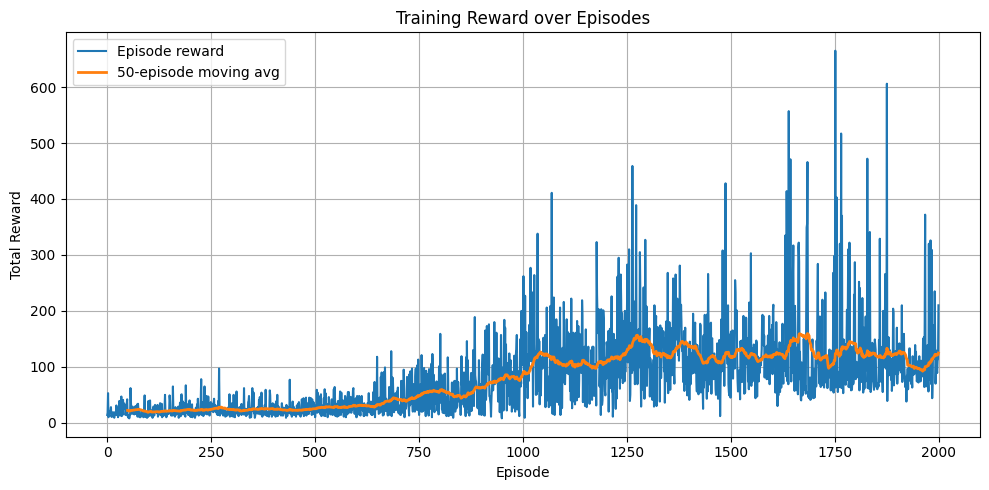

In [18]:
plot_rewards(rewards)

Now render your model's best performance based on your q table

In [19]:
_, path = record_video_cartpole(env, agent)
show_video(path)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Direct Evaluation

Now, you will perform **Direct Evaluation** to estimate the state-value function `V(s)`of your environment under the policy learned by your Q-Learning agent.

In Direct Evaluation, you use **sampling**: by running episodes following the learned policy, you collect returns (cumulative rewards) and use them to estimate the expected value of each state. 

Specifically, for each state `s`, you estimate `V(s)` as the average of the total rewards observed starting from that state, following the current policy.

This method allows you to approximate the true value function without requiring access to the full model of the environment.

You must first calculate the real `V` from the agent's learned q table, then use the above method to estimate `V` to evaluate the model's quality.

In [20]:
import numpy as np
from collections import defaultdict

def evaluate(env: CartPoleEnv, agent: QLearningAgent, gamma=0.99, episodes=10000):
    V = {}
    V_hat = {}
    
    states_in_q = set(s for (s, a) in agent.Q_table.keys())
    for state in states_in_q:
        q_values = [agent.Q_table.get((state, a), 0.0) for a in range(env.action_space.n)]
        V[state] = max(q_values)
    
    V_hat_sum = defaultdict(float)
    V_hat_count = defaultdict(int)
    
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        episode = []
        
        while not done:
            state = agent.obs_to_state(obs)
            action = agent.act(state, greedy=True)
            next_obs, reward, done, _, _ = env.step(action)
            episode.append((state, reward))
            obs = next_obs
        
        G = 0.0
        for t in reversed(range(len(episode))):
            state, reward = episode[t]
            G = reward + gamma * G
            V_hat_sum[state] += G
            V_hat_count[state] += 1
    
    V_hat = {state: V_hat_sum[state] / V_hat_count[state] for state in V_hat_sum}
    
    common_states = set(V.keys()) & set(V_hat.keys())
    if not common_states:
        return 0.0
    
    differences = [V[state] - V_hat[state] for state in common_states]
    return np.linalg.norm(differences)

In [21]:
print(evaluate(env, agent))

757.7331576727435
